In [1]:
import numpy
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
import math
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
 
# tensorflow.reset_default_graph()
tensorflow.random.set_seed(0)
# random.seed(0)
numpy.random.seed(0)

In [2]:
def create_dataset(dataset, look_back=14, day_offset=5):
    dataX, dataY= [],[]
    dataX=numpy.zeros([(len(dataset)-look_back),4,look_back])
    
    #print(dataX.shape)
    for i in range(look_back,len(dataset)):
       # print(i)
        a = numpy.zeros([4,look_back])
        t1=dataset[(i-look_back):i, 0]
        t1=numpy.reshape(t1,[1,look_back])
        t4=dataset[(i-look_back):i, 48]
        t4=numpy.reshape(t4,[1,look_back])
        #print(t1.shape)
        t2=dataset[i, 48-look_back:48]
        t2=numpy.reshape(t2,[1,look_back])
        t6=dataset[i,-(look_back+3):-3]
        t6=numpy.reshape(t6,[1,look_back])
#         t3=numpy.zeros([1,look_back])
#         if i>=((day_offset+1)*7+look_back):
#             t3[0,0:day_offset]=[dataset[j,0] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
#         t5=numpy.zeros([1,look_back])
#         if i>=((day_offset+1)*7+look_back):
#             t5[0,0:day_offset]=[dataset[j,48] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
            
            
        #print(t2.shape)
        a[0,:] = t1
        a[1,:] = t4
        a[2,:] = t2
        a[3,:] = t6
        
        dataX[i-look_back,:,:]=a
#         a = numpy.concatenate([dataset[(i-look_back-7):i-7, 0], dataset[i,-14:]],axis=1)
        
        #dataX.append(a)
        dataY.append(dataset[i,-1])
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
def missing_values(datarange, categorical=[]):  
    datarange= pd.DataFrame(datarange)
    if not categorical:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
    else:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
        
        modedata = datarange.mode()
        modedata = modedata.to_numpy()
        modedata = modedata[0,:]
        
        for i in categorical:
                meandata[i-1] = modedata[i]
                
    datetime_series = pd.to_datetime(datarange['fltdat'])
    miss_idx=pd.date_range(start = '01-01-2015', end = '31-12-2019' ).difference(datetime_series)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    datarange=datarange.set_index(datetime_index)

    datarange.drop('fltdat',axis=1,inplace=True)
    newidx = pd.date_range('01-01-2015', '31-12-2019')
    datarange = datarange.reindex(newidx, fill_value=0)
    
    meandata=meandata.reshape(1,meandata.shape[0])
    dat = numpy.tile(meandata, [miss_idx.shape[0],1])
    datarange.loc[miss_idx]=dat
    return datarange

In [4]:
def mean_absolute_percentage_error(y_test, y_pred):
        import numpy as np
        t = np.array(y_test)
        p = np.array(y_pred)
        mae = list()
        mape = list()
        for i in range(len(t)):
            if (t[i] == 0):
                mae.append(abs(p[i]))
            else:
                mae.append(float(abs(t[i] - p[i])))
                mape.append(float(abs((t[i] - p[i])/t[i])))
        return np.mean(mae) , np.mean(mape)

In [5]:
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('data/rmscapfc.csv', parse_dates=['fltdat'],dayfirst=True)
print(dataframe.columns)
dataframe.drop(dataframe.columns[[2,3,4,6,8,9,10,56,57,58,59,60,61,62] ], axis=1, inplace=True)

dataframe2 = read_csv('data/rmscapy.csv', parse_dates=['fltdat'],dayfirst=True)
# print(dataframe2.columns)
f_column = dataframe2[["paxcnty", "dcp_51", "dcp_50", "dcp_49", "dcp_48", "dcp_47", "dcp_46",
       "dcp_45", "dcp_44", "dcp_43", "dcp_42", "dcp_41", "dcp_40", "dcp_39",
       "dcp_38", "dcp_37", "dcp_36", "dcp_35", "dcp_34", "dcp_33", "dcp_3",
       "dcp_31", "dcp_30", "dcp_29", "dcp_28", "dcp_27", "dcp_26", "dcp_25",
       "dcp_24", "dcp_23", "dcp_22", "dcp_21", "dcp_20", "dcp_19", "dcp_18",
       "dcp_17", "dcp_16", "dcp_15", "dcp_14", "dcp_13", "dcp_12", "dcp_11",
       "dcp_10", "dcp_9", "dcp_8"]]
 

dataframe = pd.concat([dataframe,f_column], axis = 1)
# print(dataframe.columns)
dataframe3 = read_csv('data/uldfc.csv', parse_dates=['fltdat'],dayfirst=True)

dataframe3.drop(dataframe3.columns[[1,2,3] ], axis=1, inplace=True)
dataframe4 = read_csv('data/uldy.csv', parse_dates=['fltdat'],dayfirst=True)
dataframe4.drop(dataframe4.columns[[1,2,3] ], axis=1, inplace=True)
f_column = dataframe4[["county"]]
dataframe3 = pd.concat([dataframe3,f_column], axis = 1)
print(dataframe.columns)

Index(['fltdat', 'paxcntfc', 'fltnum', 'legorg', 'legdst', 'acrtypcod',
       'keyidr', 'totpaylodwgt', 'totpaylodvol', 'totpaylodpos', 'totsetfc',
       'totpaxwgt', 'dp_51', 'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46',
       'dp_45', 'dp_44', 'dp_43', 'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38',
       'dp_37', 'dp_36', 'dp_35', 'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30',
       'dp_29', 'dp_28', 'dp_27', 'dp_26', 'dp_25', 'dp_24', 'dp_23', 'dp_22',
       'dp_21', 'dp_20', 'dp_19', 'dp_18', 'dp_17', 'dp_16', 'dp_15', 'dp_14',
       'dp_13', 'dp_12', 'dp_11', 'dp_10', 'dp_9', 'dp_8', 'dp_7', 'dp_6',
       'dp_5', 'dp_4', 'dp_3', 'dp_2', 'dp_1'],
      dtype='object')
Index(['fltdat', 'paxcntfc', 'acrtypcod', 'totpaylodwgt', 'totpaxwgt', 'dp_51',
       'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46', 'dp_45', 'dp_44', 'dp_43',
       'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38', 'dp_37', 'dp_36', 'dp_35',
       'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30', 'dp_29', 'dp_28', 'dp_27',

In [6]:
NUM=[0,1825,1825,1817,1816,1812,1821,1825,1824,1819,1825,1825,1824,1826,1819,1825,1822,1823,1813, 1826, 1820]
NUMuld=[0,1817,1574,1808,1802,1807,1808,1730,1817,1385,1820,1816,1606,1819,1810,1817,421,1813,434,1532,1814]
cat_inp=[2]

In [7]:
# dataset, datasetY = numpy.empty([1805,3,look_back]), []
for i in range(0,len(NUM)-1):
#     print(i)
    datasub = dataframe.iloc[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasub = missing_values(datasub, cat_inp)
    datasub = datasub.values
    datasub = datasub.astype('float32')
    
    datasubuld = dataframe3.iloc[sum(NUMuld[0:i+1]):sum(NUMuld[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasubuld = missing_values(datasubuld)
    datasubuld = datasubuld.values
    datasubuld = datasubuld.astype('float32')
    
    datasub = numpy.concatenate([datasub, datasubuld], axis=1)
    if i==0:
        data = datasub
    else:
        data = numpy.concatenate([data, datasub], axis =0)
 

C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  import sys
C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


In [8]:
out = data[:,2] - data[:,3] - (data[:,-1]*data[:,-2]*114)
out = out.reshape(out.shape[0],1)
data = numpy.concatenate([data,out], axis=1)
print(data.shape)

(36520, 96)


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

In [10]:
def sequence_data_build(data, look_back):
    for i in range(0,20):
        datasub = data[i*1826:((i+1)*1826),:]
        X, Y = create_dataset(datasub, look_back)
        Y = Y.reshape(Y.shape[0],1)
        if i==0: 
            data_LSTM_X = X
            data_LSTM_Y = Y
        else:
            data_LSTM_X = numpy.concatenate([data_LSTM_X, X],axis=0)
            data_LSTM_Y = numpy.concatenate([data_LSTM_Y, Y],axis=0)
    return data_LSTM_X, data_LSTM_Y

In [23]:
def train_test_build(X, Y, m1, m2):
    spliter = int(X.shape[0]/20)
    tot_len = m1
    train_len = m2
    for i in range(0,20):
        Xsub = X[i*spliter:((i+1)*spliter),:]
        Ysub = Y[i*spliter:((i+1)*spliter)]
        if i==0:
            trainX = Xsub[0:m2,:]
            testX = Xsub[m2:m1,:]
            trainY = Ysub[0:m2]
            testY = Ysub[m2:m1]
        else:
            trainX = numpy.concatenate([trainX, Xsub[0:m2,:]], axis=0)
            testX = numpy.concatenate([testX, Xsub[m2:m1,:]], axis=0)
            trainY = numpy.concatenate([trainY, Ysub[0:m2]], axis=0)
            testY = numpy.concatenate([testY, Ysub[m2:m1]], axis=0)
        
    return trainX, trainY, testX, testY

In [16]:
def model_build(trainX, trainY, testX, testY, units, saving =False, month=None, EarlyStop = False):
    
    if EarlyStop:
        callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                            mode = 'min', restore_best_weights=True)
                                                            
    model = Sequential()
    model.add(LSTM(units, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    if EarlyStop:
        history = model.fit(trainX, trainY, epochs=100, batch_size=150, validation_data=(testX, testY),verbose=1,
                            callbacks=[callback])
    else:
        history = model.fit(trainX, trainY, epochs=100, batch_size=150, validation_data=(testX, testY),verbose=1, )#callbacks=[callback]
                  
    testPredict = model.predict(testX)
                
    sh = testPredict.shape
    inv_yhat = testPredict.reshape(sh[0]*sh[1],1)
    inv_yhat = numpy.concatenate([ data[0:inv_yhat.shape[0],0:95], inv_yhat], axis=1)

    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]
    testY = testY.reshape(sh[0]*sh[1],1)
 
    inv_y = numpy.concatenate([data[0:testY.shape[0],0:95], testY], axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
             
    rmse = numpy.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae, mape = mean_absolute_percentage_error(inv_y, inv_yhat) 
    r2 = r2_score(inv_y, inv_yhat)
    
    res=[]
    if saving:
        inv_y = inv_y.reshape(inv_y.shape[0],1) 
        inv_yhat = inv_yhat.reshape(inv_yhat.shape[0],1) 
        res = numpy.concatenate([inv_y, inv_yhat], axis=1)
        df = pd.DataFrame(res)
        res = df.to_csv("ds_" + month + ".csv", index = False)
    return rmse, mape,mae,r2, history

In [21]:
def cross_validation(lag_vec = [7,14,21,28], units_vec = [2,4,8,16,32,64,128]):
    results = numpy.zeros([4,3,len(lag_vec),len(units_vec)])
    
    for folds in range(0,3):
        for i in range(0,len(lag_vec)):
            data_LSTM_X, data_LSTM_Y = sequence_data_build(data, lag_vec[i])
            totday = int(data_LSTM_X.shape[0]/20)
#             print(totday)
            m1 = [totday-152, totday-121, totday-91, ]
            m2 = [m1[0]-31, m1[1]-31, m1[2]-30, ]
            lag = lag_vec[i]
            trainX, trainY, testX, testY= train_test_build(data_LSTM_X, data_LSTM_Y, m1[folds], m2[folds])
            testYcopy=testY
            for j in range(0, len(units_vec)):
                print(" ")
                print(" ")
                print(" ")
                print("------------------------------------------------")
                print("fold: {0}, lag: {1}, units: {2}".format(folds, lag_vec[i], units_vec[j]))
                units = units_vec[j]
                rmse, mape, mae, r2, his = model_build(trainX, trainY, testX, testY, units, EarlyStop=True) 
                results[0,folds,i,j] = rmse 
                results[2,folds,i,j], results[1,folds,i,j] = mae, mape
                results[3,folds,i,j] = r2
    return results        

In [24]:
lag_vec = [7,14]
units_vec = [2,4,8,16,32,64,128]
results = cross_validation(lag_vec, units_vec)


 
 
 
------------------------------------------------
fold: 0, lag: 7, units: 2
Train on 32720 samples, validate on 620 samples
Epoch 1/100
32720/32720 [==============================] - 6s 189us/sample - loss: 0.1883 - val_loss: 0.1412
Epoch 2/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1532 - val_loss: 0.1174
Epoch 3/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1418 - val_loss: 0.1116
Epoch 4/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.1379 - val_loss: 0.1118
Epoch 5/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1353 - val_loss: 0.1048
Epoch 6/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1331 - val_loss: 0.1039
Epoch 7/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1312 - val_loss: 0.1031
Epoch 8/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1296 - val_loss: 0.1015
Epoch 

32720/32720 [==============================] - 2s 53us/sample - loss: 0.1163 - val_loss: 0.0967
Epoch 76/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1163 - val_loss: 0.0964
Epoch 77/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1163 - val_loss: 0.0974
Epoch 78/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1162 - val_loss: 0.0950
Epoch 79/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1161 - val_loss: 0.0942
Epoch 80/100
32720/32720 [==============================] - 2s 53us/sample - loss: 0.1162 - val_loss: 0.0977
Epoch 81/100
32720/32720 [==============================] - 2s 51us/sample - loss: 0.1160 - val_loss: 0.1002
Epoch 82/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1160 - val_loss: 0.1009
Epoch 83/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.1159 - val_loss: 0.0963
Epoch 84/100
32720/32720 [======

32720/32720 [==============================] - 2s 55us/sample - loss: 0.1082 - val_loss: 0.0811
Epoch 24/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.1076 - val_loss: 0.0781
Epoch 25/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.1071 - val_loss: 0.0779
Epoch 26/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1067 - val_loss: 0.0784
Epoch 27/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1062 - val_loss: 0.0772
Epoch 28/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.1057 - val_loss: 0.0824
Epoch 29/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.1055 - val_loss: 0.0784
Epoch 30/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1050 - val_loss: 0.0799
Epoch 31/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1045 - val_loss: 0.0731
Epoch 32/100
32720/32720 [======

32720/32720 [==============================] - 2s 52us/sample - loss: 0.0968 - val_loss: 0.0700
Epoch 73/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.0965 - val_loss: 0.0661
Epoch 74/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.0964 - val_loss: 0.0652
Epoch 75/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.0965 - val_loss: 0.0673
Epoch 76/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.0964 - val_loss: 0.0687
Epoch 77/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.0962 - val_loss: 0.0691
Epoch 78/100
32720/32720 [==============================] - 2s 52us/sample - loss: 0.0962 - val_loss: 0.0666
Epoch 79/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.0962 - val_loss: 0.0681
Epoch 80/100
32720/32720 [==============================] - 2s 53us/sample - loss: 0.0960 - val_loss: 0.0674
Epoch 81/100
32720/32720 [======

32720/32720 [==============================] - 2s 57us/sample - loss: 0.1029 - val_loss: 0.0851
Epoch 21/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.1029 - val_loss: 0.0731
Epoch 22/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1018 - val_loss: 0.0718
Epoch 23/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1014 - val_loss: 0.0684
Epoch 24/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.1007 - val_loss: 0.0680
Epoch 25/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.1000 - val_loss: 0.0672
Epoch 26/100
32720/32720 [==============================] - 2s 53us/sample - loss: 0.0996 - val_loss: 0.0724
Epoch 27/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.0990 - val_loss: 0.0672
Epoch 28/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.0986 - val_loss: 0.0730
Epoch 29/100
32720/32720 [======

32720/32720 [==============================] - 2s 50us/sample - loss: 0.0874 - val_loss: 0.0520
Epoch 70/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.0874 - val_loss: 0.0526
Epoch 71/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.0872 - val_loss: 0.0590
Epoch 72/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.0870 - val_loss: 0.0555
Epoch 73/100
32720/32720 [==============================] - 2s 53us/sample - loss: 0.0870 - val_loss: 0.0534
Epoch 74/100
32720/32720 [==============================] - 2s 54us/sample - loss: 0.0870 - val_loss: 0.0544
Epoch 75/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.0868 - val_loss: 0.0524
Epoch 76/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.0865 - val_loss: 0.0553
Epoch 77/100
32720/32720 [==============================] - 2s 55us/sample - loss: 0.0864 - val_loss: 0.0519
Epoch 78/100
32720/32720 [======

32580/32580 [==============================] - 2s 54us/sample - loss: 0.1148 - val_loss: 0.0976
Epoch 18/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.1140 - val_loss: 0.0908
Epoch 19/100
32580/32580 [==============================] - 2s 60us/sample - loss: 0.1135 - val_loss: 0.0934
Epoch 20/100
32580/32580 [==============================] - 2s 59us/sample - loss: 0.1129 - val_loss: 0.0945
Epoch 21/100
32580/32580 [==============================] - 2s 55us/sample - loss: 0.1123 - val_loss: 0.0896
Epoch 22/100
32580/32580 [==============================] - 2s 54us/sample - loss: 0.1117 - val_loss: 0.0941
Epoch 23/100
32580/32580 [==============================] - 2s 55us/sample - loss: 0.1113 - val_loss: 0.0919
Epoch 24/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.1111 - val_loss: 0.0968
Epoch 25/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.1105 - val_loss: 0.0904
Epoch 26/100
32580/32580 [======

32580/32580 [==============================] - 2s 55us/sample - loss: 0.0944 - val_loss: 0.0629
Epoch 67/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0944 - val_loss: 0.0608
Epoch 68/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.0943 - val_loss: 0.0672
Epoch 69/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.0946 - val_loss: 0.0625
Epoch 70/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0942 - val_loss: 0.0626
Epoch 71/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0941 - val_loss: 0.0611
Epoch 72/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.0942 - val_loss: 0.0640
Epoch 73/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.0937 - val_loss: 0.0615
Epoch 74/100
32580/32580 [==============================] - 2s 54us/sample - loss: 0.0938 - val_loss: 0.0621
Epoch 75/100
32580/32580 [======

32580/32580 [==============================] - 2s 52us/sample - loss: 0.1092 - val_loss: 0.0870
Epoch 15/100
32580/32580 [==============================] - 2s 52us/sample - loss: 0.1081 - val_loss: 0.0895
Epoch 16/100
32580/32580 [==============================] - 2s 53us/sample - loss: 0.1073 - val_loss: 0.0868
Epoch 17/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.1061 - val_loss: 0.0863
Epoch 18/100
32580/32580 [==============================] - 2s 55us/sample - loss: 0.1059 - val_loss: 0.0832
Epoch 19/100
32580/32580 [==============================] - 2s 53us/sample - loss: 0.1049 - val_loss: 0.0842
Epoch 20/100
32580/32580 [==============================] - 2s 53us/sample - loss: 0.1039 - val_loss: 0.0762
Epoch 21/100
32580/32580 [==============================] - 2s 55us/sample - loss: 0.1030 - val_loss: 0.0756
Epoch 22/100
32580/32580 [==============================] - 2s 55us/sample - loss: 0.1024 - val_loss: 0.0768
Epoch 23/100
32580/32580 [======

32580/32580 [==============================] - 2s 58us/sample - loss: 0.0876 - val_loss: 0.0583
Epoch 64/100
32580/32580 [==============================] - 2s 52us/sample - loss: 0.0871 - val_loss: 0.0569
Epoch 65/100
32580/32580 [==============================] - 2s 47us/sample - loss: 0.0869 - val_loss: 0.0570
Epoch 66/100
32580/32580 [==============================] - 2s 47us/sample - loss: 0.0871 - val_loss: 0.0539
Epoch 67/100
32580/32580 [==============================] - 2s 51us/sample - loss: 0.0864 - val_loss: 0.0574
Epoch 68/100
32580/32580 [==============================] - 2s 50us/sample - loss: 0.0867 - val_loss: 0.0605
Epoch 69/100
32580/32580 [==============================] - 2s 54us/sample - loss: 0.0867 - val_loss: 0.0586
Epoch 70/100
32580/32580 [==============================] - 2s 53us/sample - loss: 0.0863 - val_loss: 0.0584
Epoch 71/100
32580/32580 [==============================] - 2s 52us/sample - loss: 0.0861 - val_loss: 0.0549
Epoch 72/100
32580/32580 [======

33340/33340 [==============================] - 2s 58us/sample - loss: 0.1244 - val_loss: 0.1088
Epoch 12/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1237 - val_loss: 0.1098
Epoch 13/100
33340/33340 [==============================] - 2s 54us/sample - loss: 0.1231 - val_loss: 0.1091
Epoch 14/100
33340/33340 [==============================] - 2s 59us/sample - loss: 0.1224 - val_loss: 0.1085
Epoch 15/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1218 - val_loss: 0.1068
Epoch 16/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1210 - val_loss: 0.1068
Epoch 17/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1203 - val_loss: 0.1064
Epoch 18/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.1198 - val_loss: 0.1034
Epoch 19/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1192 - val_loss: 0.1058
Epoch 20/100
33340/33340 [======

33340/33340 [==============================] - 2s 54us/sample - loss: 0.1070 - val_loss: 0.0901
Epoch 61/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1068 - val_loss: 0.0920
Epoch 62/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1064 - val_loss: 0.0918
Epoch 63/100
33340/33340 [==============================] - 2s 54us/sample - loss: 0.1063 - val_loss: 0.0890
Epoch 64/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1060 - val_loss: 0.0899
Epoch 65/100
33340/33340 [==============================] - 2s 54us/sample - loss: 0.1057 - val_loss: 0.0902
Epoch 66/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.1058 - val_loss: 0.0880
Epoch 67/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1054 - val_loss: 0.0863
Epoch 68/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1052 - val_loss: 0.0885
Epoch 69/100
33340/33340 [======

33340/33340 [==============================] - 2s 55us/sample - loss: 0.1178 - val_loss: 0.0973
Epoch 9/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.1177 - val_loss: 0.1018
Epoch 10/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1170 - val_loss: 0.1008
Epoch 11/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1163 - val_loss: 0.1096
Epoch 12/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1161 - val_loss: 0.0998
Epoch 13/100
33340/33340 [==============================] - 2s 54us/sample - loss: 0.1156 - val_loss: 0.1147
Epoch 14/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1153 - val_loss: 0.1008
Epoch 15/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1143 - val_loss: 0.1070
Epoch 16/100
33340/33340 [==============================] - 2s 53us/sample - loss: 0.1138 - val_loss: 0.1015
Epoch 17/100
33340/33340 [=======

33340/33340 [==============================] - 2s 56us/sample - loss: 0.0949 - val_loss: 0.0728
Epoch 58/100
33340/33340 [==============================] - 2s 52us/sample - loss: 0.0946 - val_loss: 0.0727
Epoch 59/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0947 - val_loss: 0.0719
Epoch 60/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.0942 - val_loss: 0.0794
Epoch 61/100
33340/33340 [==============================] - 2s 54us/sample - loss: 0.0945 - val_loss: 0.0755
Epoch 62/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.0944 - val_loss: 0.0781
Epoch 63/100
33340/33340 [==============================] - 2s 52us/sample - loss: 0.0939 - val_loss: 0.0682
Epoch 64/100
33340/33340 [==============================] - 2s 54us/sample - loss: 0.0939 - val_loss: 0.0700
Epoch 65/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.0936 - val_loss: 0.0754
Epoch 66/100
33340/33340 [======

33340/33340 [==============================] - 2s 46us/sample - loss: 0.1187 - val_loss: 0.1163
Epoch 6/100
33340/33340 [==============================] - 2s 47us/sample - loss: 0.1183 - val_loss: 0.1177
Epoch 7/100
33340/33340 [==============================] - 2s 51us/sample - loss: 0.1167 - val_loss: 0.0991
Epoch 8/100
33340/33340 [==============================] - 2s 53us/sample - loss: 0.1154 - val_loss: 0.0951
Epoch 9/100
33340/33340 [==============================] - 2s 49us/sample - loss: 0.1130 - val_loss: 0.0963
Epoch 10/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.1110 - val_loss: 0.0927
Epoch 11/100
33340/33340 [==============================] - 2s 50us/sample - loss: 0.1092 - val_loss: 0.0930
Epoch 12/100
33340/33340 [==============================] - 2s 51us/sample - loss: 0.1074 - val_loss: 0.0869
Epoch 13/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1048 - val_loss: 0.0863
Epoch 14/100
33340/33340 [==========

33200/33200 [==============================] - 2s 53us/sample - loss: 0.1056 - val_loss: 0.0909
Epoch 55/100
33200/33200 [==============================] - 2s 53us/sample - loss: 0.1055 - val_loss: 0.0935
Epoch 56/100
33200/33200 [==============================] - 2s 53us/sample - loss: 0.1056 - val_loss: 0.0970
Epoch 57/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.1054 - val_loss: 0.0942
Epoch 58/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.1056 - val_loss: 0.0872
Epoch 59/100
33200/33200 [==============================] - 2s 50us/sample - loss: 0.1055 - val_loss: 0.0900
Epoch 60/100
33200/33200 [==============================] - 2s 49us/sample - loss: 0.1052 - val_loss: 0.0938
Epoch 61/100
33200/33200 [==============================] - 2s 51us/sample - loss: 0.1052 - val_loss: 0.0919
Epoch 62/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.1050 - val_loss: 0.0896
Epoch 63/100
33200/33200 [======

33200/33200 [==============================] - 2s 58us/sample - loss: 0.1260 - val_loss: 0.1081
Epoch 3/100
33200/33200 [==============================] - 2s 61us/sample - loss: 0.1188 - val_loss: 0.0958
Epoch 4/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.1164 - val_loss: 0.0948
Epoch 5/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.1145 - val_loss: 0.1011
Epoch 6/100
33200/33200 [==============================] - 2s 53us/sample - loss: 0.1127 - val_loss: 0.1083
Epoch 7/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.1113 - val_loss: 0.0981
Epoch 8/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.1101 - val_loss: 0.0976
Epoch 9/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.1087 - val_loss: 0.1007
Epoch 10/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.1072 - val_loss: 0.0900
Epoch 11/100
33200/33200 [=============

33200/33200 [==============================] - 2s 55us/sample - loss: 0.0928 - val_loss: 0.0795
Epoch 52/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.0929 - val_loss: 0.0755
Epoch 53/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0929 - val_loss: 0.0792
Epoch 54/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0928 - val_loss: 0.0785
Epoch 55/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.0929 - val_loss: 0.0802
Epoch 56/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.0926 - val_loss: 0.0686
Epoch 57/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.0924 - val_loss: 0.0695
Epoch 58/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0925 - val_loss: 0.0730
Epoch 59/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0920 - val_loss: 0.0715
Epoch 60/100
33200/33200 [======

33200/33200 [==============================] - 2s 55us/sample - loss: 0.0863 - val_loss: 0.0624
 
 
 
------------------------------------------------
fold: 1, lag: 14, units: 64
Train on 33200 samples, validate on 620 samples
Epoch 1/100
33200/33200 [==============================] - 4s 135us/sample - loss: 0.1339 - val_loss: 0.1026
Epoch 2/100
33200/33200 [==============================] - 2s 53us/sample - loss: 0.1183 - val_loss: 0.1122
Epoch 3/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.1161 - val_loss: 0.1038
Epoch 4/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.1150 - val_loss: 0.1001
Epoch 5/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.1140 - val_loss: 0.1069
Epoch 6/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.1133 - val_loss: 0.1069
Epoch 7/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.1129 - val_loss: 0.1024
Epoch 8/100
3320

33200/33200 [==============================] - 2s 57us/sample - loss: 0.0855 - val_loss: 0.0607
Epoch 49/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0850 - val_loss: 0.0633
Epoch 50/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0850 - val_loss: 0.0632
Epoch 51/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0848 - val_loss: 0.0616
Epoch 52/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0844 - val_loss: 0.0647
Epoch 53/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0841 - val_loss: 0.0616
Epoch 54/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0838 - val_loss: 0.0614
Epoch 55/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0837 - val_loss: 0.0639
Epoch 56/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.0834 - val_loss: 0.0658
Epoch 57/100
33200/33200 [======

33960/33960 [==============================] - 2s 52us/sample - loss: 0.1137 - val_loss: 0.1098
Epoch 98/100
33960/33960 [==============================] - 2s 53us/sample - loss: 0.1136 - val_loss: 0.1082
Epoch 99/100
33960/33960 [==============================] - 2s 53us/sample - loss: 0.1135 - val_loss: 0.1100
Epoch 100/100
33960/33960 [==============================] - 2s 53us/sample - loss: 0.1135 - val_loss: 0.1083
 
 
 
------------------------------------------------
fold: 2, lag: 7, units: 4
Train on 33960 samples, validate on 600 samples
Epoch 1/100
33960/33960 [==============================] - 5s 133us/sample - loss: 0.1794 - val_loss: 0.1495
Epoch 2/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1394 - val_loss: 0.1188
Epoch 3/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1265 - val_loss: 0.1157
Epoch 4/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1221 - val_loss: 0.1178
Epoch 5/100
33

33960/33960 [==============================] - 2s 55us/sample - loss: 0.1072 - val_loss: 0.1002
Epoch 46/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1070 - val_loss: 0.1019
Epoch 47/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.1064 - val_loss: 0.1028
Epoch 48/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1064 - val_loss: 0.1003
Epoch 49/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1061 - val_loss: 0.1026
Epoch 50/100
33960/33960 [==============================] - 2s 53us/sample - loss: 0.1060 - val_loss: 0.1002
Epoch 51/100
33960/33960 [==============================] - 2s 50us/sample - loss: 0.1053 - val_loss: 0.0987
Epoch 52/100
33960/33960 [==============================] - 2s 54us/sample - loss: 0.1054 - val_loss: 0.0995
Epoch 53/100
33960/33960 [==============================] - 2s 54us/sample - loss: 0.1052 - val_loss: 0.0981
Epoch 54/100
33960/33960 [======

33960/33960 [==============================] - 2s 55us/sample - loss: 0.0927 - val_loss: 0.0820
Epoch 95/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0925 - val_loss: 0.0846
Epoch 96/100
33960/33960 [==============================] - 2s 51us/sample - loss: 0.0925 - val_loss: 0.0861
Epoch 97/100
33960/33960 [==============================] - 2s 51us/sample - loss: 0.0924 - val_loss: 0.0867
Epoch 98/100
33960/33960 [==============================] - 2s 54us/sample - loss: 0.0922 - val_loss: 0.0835
Epoch 99/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.0923 - val_loss: 0.0998
Epoch 100/100
33960/33960 [==============================] - 2s 52us/sample - loss: 0.0923 - val_loss: 0.0838
 
 
 
------------------------------------------------
fold: 2, lag: 7, units: 32
Train on 33960 samples, validate on 600 samples
Epoch 1/100
33960/33960 [==============================] - 5s 146us/sample - loss: 0.1455 - val_loss: 0.1130
Epoch 2/10

33960/33960 [==============================] - 2s 53us/sample - loss: 0.0941 - val_loss: 0.0908
Epoch 43/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0936 - val_loss: 0.0861
Epoch 44/100
33960/33960 [==============================] - 2s 53us/sample - loss: 0.0934 - val_loss: 0.0861
Epoch 45/100
33960/33960 [==============================] - 2s 52us/sample - loss: 0.0931 - val_loss: 0.0842
Epoch 46/100
33960/33960 [==============================] - 2s 54us/sample - loss: 0.0931 - val_loss: 0.0826
Epoch 47/100
33960/33960 [==============================] - 2s 53us/sample - loss: 0.0929 - val_loss: 0.0865
Epoch 48/100
33960/33960 [==============================] - 2s 52us/sample - loss: 0.0928 - val_loss: 0.0817
Epoch 49/100
33960/33960 [==============================] - 2s 54us/sample - loss: 0.0923 - val_loss: 0.0853
Epoch 50/100
33960/33960 [==============================] - 2s 52us/sample - loss: 0.0924 - val_loss: 0.0837
Epoch 51/100
33960/33960 [======

33960/33960 [==============================] - 2s 55us/sample - loss: 0.0836 - val_loss: 0.0798
Epoch 92/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.0836 - val_loss: 0.0887
Epoch 93/100
33960/33960 [==============================] - 2s 59us/sample - loss: 0.0832 - val_loss: 0.0835
Epoch 94/100
33960/33960 [==============================] - 2s 53us/sample - loss: 0.0831 - val_loss: 0.0776
Epoch 95/100
33960/33960 [==============================] - 2s 57us/sample - loss: 0.0831 - val_loss: 0.0773
Epoch 96/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0831 - val_loss: 0.0845
Epoch 97/100
33960/33960 [==============================] - 2s 59us/sample - loss: 0.0826 - val_loss: 0.0841
Epoch 98/100
33960/33960 [==============================] - 2s 61us/sample - loss: 0.0824 - val_loss: 0.0784
Epoch 99/100
33960/33960 [==============================] - 2s 54us/sample - loss: 0.0825 - val_loss: 0.0822
Epoch 100/100
33960/33960 [=====

33820/33820 [==============================] - 2s 55us/sample - loss: 0.1056 - val_loss: 0.1025
Epoch 40/100
33820/33820 [==============================] - 2s 53us/sample - loss: 0.1056 - val_loss: 0.1050
Epoch 41/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.1057 - val_loss: 0.1005
Epoch 42/100
33820/33820 [==============================] - 2s 56us/sample - loss: 0.1053 - val_loss: 0.1007
Epoch 43/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.1052 - val_loss: 0.0998
Epoch 44/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.1049 - val_loss: 0.0983
Epoch 45/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.1049 - val_loss: 0.0994
Epoch 46/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.1048 - val_loss: 0.0991
Epoch 47/100
33820/33820 [==============================] - 2s 61us/sample - loss: 0.1047 - val_loss: 0.1018
Epoch 48/100
33820/33820 [======

33820/33820 [==============================] - 2s 55us/sample - loss: 0.0922 - val_loss: 0.0861
Epoch 89/100
33820/33820 [==============================] - 2s 53us/sample - loss: 0.0921 - val_loss: 0.0852
Epoch 90/100
33820/33820 [==============================] - 2s 53us/sample - loss: 0.0921 - val_loss: 0.0852
Epoch 91/100
33820/33820 [==============================] - 2s 51us/sample - loss: 0.0921 - val_loss: 0.0840
Epoch 92/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0919 - val_loss: 0.0865
Epoch 93/100
33820/33820 [==============================] - 2s 52us/sample - loss: 0.0917 - val_loss: 0.0846
Epoch 94/100
33820/33820 [==============================] - 2s 52us/sample - loss: 0.0918 - val_loss: 0.0845
Epoch 95/100
33820/33820 [==============================] - 2s 53us/sample - loss: 0.0918 - val_loss: 0.0870
Epoch 96/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0915 - val_loss: 0.0842
Epoch 97/100
33820/33820 [======

33820/33820 [==============================] - 1s 44us/sample - loss: 0.0926 - val_loss: 0.0882
Epoch 37/100
33820/33820 [==============================] - 2s 48us/sample - loss: 0.0925 - val_loss: 0.0906
Epoch 38/100
33820/33820 [==============================] - 2s 50us/sample - loss: 0.0920 - val_loss: 0.0849
Epoch 39/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0919 - val_loss: 0.0883
Epoch 40/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0917 - val_loss: 0.0877
Epoch 41/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0921 - val_loss: 0.0892
Epoch 42/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0914 - val_loss: 0.0882
Epoch 43/100
33820/33820 [==============================] - 2s 56us/sample - loss: 0.0915 - val_loss: 0.0882
Epoch 44/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.0911 - val_loss: 0.0869
Epoch 45/100
33820/33820 [======

33820/33820 [==============================] - 2s 54us/sample - loss: 0.0825 - val_loss: 0.0777
Epoch 86/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.0824 - val_loss: 0.0753
Epoch 87/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.0822 - val_loss: 0.0790
Epoch 88/100
33820/33820 [==============================] - 2s 56us/sample - loss: 0.0822 - val_loss: 0.0777
Epoch 89/100
33820/33820 [==============================] - 2s 52us/sample - loss: 0.0821 - val_loss: 0.0775
Epoch 90/100
33820/33820 [==============================] - 2s 53us/sample - loss: 0.0820 - val_loss: 0.0735
Epoch 91/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.0820 - val_loss: 0.0847
Epoch 92/100
33820/33820 [==============================] - 2s 52us/sample - loss: 0.0820 - val_loss: 0.0772
Epoch 93/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0816 - val_loss: 0.0785
Epoch 94/100
33820/33820 [======

In [25]:
MAE = results[2,:]
print(MAE)
MAE = numpy.sum(MAE, axis=0)
ind = numpy.unravel_index(numpy.argmin(MAE, axis=None), MAE.shape)

lag = lag_vec[ind[0]]
units = units_vec[ind[1]]
print(lag,units)

# units = 32

[[[4822.76705007 3886.20675797 3111.28132285 3157.25823226 2826.67229004
   2764.52763042 2611.16679176]
  [4257.75325455 3528.09024304 2913.71925009 2841.22830614 2717.85612557
   2682.39862533 2808.82141586]]

 [[4678.02613447 4181.37986706 3534.93085977 3447.41044882 3426.39722388
   3093.95271705 3029.11980729]
  [4266.86248228 3804.19091127 3528.35159755 3323.83518185 3133.21773406
   3079.14930184 3032.95928089]]

 [[5436.67670614 4833.58008423 4539.20640544 4207.19189982 4320.75024089
   4116.90658244 4032.79200846]
  [5162.39343099 4597.20228841 4433.76703735 4274.6470166  4126.7024117
   3906.3002592  3881.55881083]]]
14 64


Train on 34400 samples, validate on 620 samples
Epoch 1/100
34400/34400 [==============================] - 5s 134us/sample - loss: 0.1356 - val_loss: 0.1439
Epoch 2/100
34400/34400 [==============================] - 2s 53us/sample - loss: 0.1172 - val_loss: 0.1467
Epoch 3/100
34400/34400 [==============================] - 2s 54us/sample - loss: 0.1154 - val_loss: 0.1507
Epoch 4/100
34400/34400 [==============================] - 2s 55us/sample - loss: 0.1148 - val_loss: 0.1488
Epoch 5/100
34400/34400 [==============================] - 2s 56us/sample - loss: 0.1140 - val_loss: 0.1507
Epoch 6/100
34400/34400 [==============================] - 2s 55us/sample - loss: 0.1132 - val_loss: 0.1500
Epoch 7/100
34400/34400 [==============================] - 2s 56us/sample - loss: 0.1121 - val_loss: 0.1586
Epoch 8/100
34400/34400 [==============================] - 2s 55us/sample - loss: 0.1122 - val_loss: 0.1581
Epoch 9/100
34400/34400 [==============================] - 2s 53us/sample - loss: 0.110

Epoch 76/100
34400/34400 [==============================] - 2s 54us/sample - loss: 0.0836 - val_loss: 0.1577
Epoch 77/100
34400/34400 [==============================] - 2s 53us/sample - loss: 0.0836 - val_loss: 0.1585
Epoch 78/100
34400/34400 [==============================] - 2s 53us/sample - loss: 0.0836 - val_loss: 0.1585
Epoch 79/100
34400/34400 [==============================] - 2s 55us/sample - loss: 0.0832 - val_loss: 0.1587
Epoch 80/100
34400/34400 [==============================] - 2s 53us/sample - loss: 0.0831 - val_loss: 0.1572
Epoch 81/100
34400/34400 [==============================] - 2s 52us/sample - loss: 0.0836 - val_loss: 0.1569
Epoch 82/100
34400/34400 [==============================] - 2s 53us/sample - loss: 0.0831 - val_loss: 0.1573
Epoch 83/100
34400/34400 [==============================] - 2s 54us/sample - loss: 0.0827 - val_loss: 0.1548
Epoch 84/100
34400/34400 [==============================] - 2s 52us/sample - loss: 0.0828 - val_loss: 0.1583
Epoch 85/100
34400/

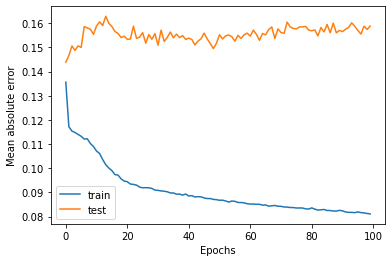

Root mean square error: 12487.1416015625
MAPE: 0.21560324525064883
MAE: 7971.335346837198
R2 score: 0.18305023430627576
 
 
---------------------------------------------------
Train on 35020 samples, validate on 600 samples
Epoch 1/100
35020/35020 [==============================] - 5s 152us/sample - loss: 0.1349 - val_loss: 0.1345
Epoch 2/100
35020/35020 [==============================] - 2s 53us/sample - loss: 0.1186 - val_loss: 0.1349
Epoch 3/100
35020/35020 [==============================] - 2s 55us/sample - loss: 0.1161 - val_loss: 0.1352
Epoch 4/100
35020/35020 [==============================] - 2s 55us/sample - loss: 0.1156 - val_loss: 0.1375
Epoch 5/100
35020/35020 [==============================] - 2s 55us/sample - loss: 0.1141 - val_loss: 0.1429
Epoch 6/100
35020/35020 [==============================] - 2s 52us/sample - loss: 0.1135 - val_loss: 0.1566
Epoch 7/100
35020/35020 [==============================] - 2s 53us/sample - loss: 0.1126 - val_loss: 0.1446
Epoch 8/100
35020/3

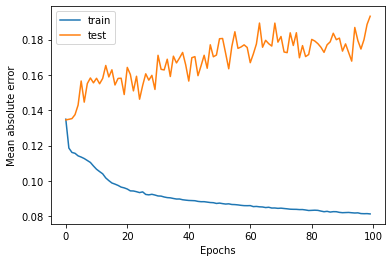

Root mean square error: 14111.8310546875
MAPE: 0.8090802180253862
MAE: 9697.569332682291
R2 score: -1.6440939324426225
 
 
---------------------------------------------------
Train on 35620 samples, validate on 620 samples
Epoch 1/100
35620/35620 [==============================] - 5s 132us/sample - loss: 0.1326 - val_loss: 0.0815
Epoch 2/100
35620/35620 [==============================] - 2s 51us/sample - loss: 0.1180 - val_loss: 0.0809
Epoch 3/100
35620/35620 [==============================] - 2s 52us/sample - loss: 0.1160 - val_loss: 0.0809
Epoch 4/100
35620/35620 [==============================] - 2s 50us/sample - loss: 0.1158 - val_loss: 0.0814
Epoch 5/100
35620/35620 [==============================] - 2s 53us/sample - loss: 0.1149 - val_loss: 0.0797
Epoch 6/100
35620/35620 [==============================] - 2s 56us/sample - loss: 0.1134 - val_loss: 0.0804
Epoch 7/100
35620/35620 [==============================] - 2s 52us/sample - loss: 0.1123 - val_loss: 0.0797
Epoch 8/100
35620/35

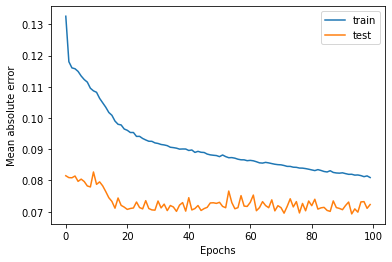

Root mean square error: 5542.84375
MAPE: 0.13364083289538206
MAE: 3627.847345955141
R2 score: 0.48519575978271434
 
 
---------------------------------------------------


In [28]:
# Testing
# lag=14
ds=['october','november','december']

data_LSTM_X, data_LSTM_Y = sequence_data_build(data, lag)
totday = int(data_LSTM_X.shape[0]/20)
m1 = [totday-61, totday-31, totday, ]
m2 = [m1[0]-31, m1[1]-30, m1[2]-31, ]
for i in range(len(m1)):
    trainX, trainY, testX, testY = train_test_build(data_LSTM_X, data_LSTM_Y, m1[i], m2[i])
    testYcopy=testY
    saving = True
    EarlyStop = True
    rmse, mape, mae, r2, history = model_build(trainX, trainY, testX, testY, units, saving, ds[i])
        
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Mean absolute error")
    pyplot.savefig("SM2F_" + ds[i] + ".png")
    pyplot.show()
    
    
    print("Root mean square error: {0}".format(rmse))
    print("MAPE: {0}".format(mape))
    print("MAE: {0}".format(mae))
    print("R2 score: {0}".format(r2))
    print(" ")
    print(" ")
    print("---------------------------------------------------")

In [30]:
print("lag vector")
print(lag_vec)
print("LSTM units")
print(units_vec)
print("Cross-validation results")
print(lag,units)
print("----------------------------")
print("RMSE")
print(results[0,:])

print("----------------------------")
print("MAE")
print(results[1,:])

print("----------------------------")
print("MAPE")
print(results[2,:])

print("----------------------------")
print("R2-score")
print(results[3,:])

lag vector
[7, 14]
LSTM units
[2, 4, 8, 16, 32, 64, 128]
Cross-validation results
14 64
----------------------------
RMSE
[[[6270.82080078 5260.97314453 4387.34326172 4482.60009766 4100.24658203
   4066.93164062 3902.28417969]
  [5701.08105469 4862.9765625  4068.1953125  4014.50341797 3809.52416992
   3844.63891602 4052.32250977]]

 [[6299.99560547 5755.0703125  5071.83789062 4916.08251953 5006.66455078
   4596.02392578 4345.10400391]
  [5798.83447266 5231.83789062 4950.19140625 4827.86816406 4438.41845703
   4477.07324219 4371.40429688]]

 [[8054.99121094 7558.93701172 7060.42138672 6622.62353516 6839.13134766
   6735.82080078 6660.04931641]
  [7782.54248047 7225.49414062 6855.95605469 6759.65429688 6748.21337891
   6414.30664062 6358.10009766]]]
----------------------------
MAE
[[[0.30030921 0.21361311 0.12598986 0.12768412 0.11348939 0.103996
   0.09985002]
  [0.20893302 0.15592491 0.11132591 0.10836389 0.11878732 0.10015129
   0.10227432]]

 [[0.26636167 0.22359581 0.14894052 0.149

In [31]:
totday

1812